In [1]:
%matplotlib inline

In [2]:
import numpy as np
import kali.carma
import kali
import gatspy
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [14,8]
from lsstlc import * # derived LSST lightcurve sub-class

/home/kali/python/kali/lc.py:29: UserWarning: No display environment! Using matplotlib backend "Agg"
  warnings.warn('No display environment! Using matplotlib backend "Agg"')
/home/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Opsim minion_1016 & CARMA(1,0)

In [3]:
npz = np.load('/home/mount/obs_hist.npz') # load MAF output from file, which was saved from the obs_hist notebook
pos_gap = npz['pos_gap'] # [ra, dec, min_gap], min_gap in hours
obsHist = npz['obsHist'] # obsHist in structured array

### CARMA(1,0) task

In [4]:
# Initiate carma task
Task = kali.carma.CARMATask(1,0,nsteps = 500)

In [5]:
# declare input timescales and amplitude, organize in an array
r_1 = (-1.0/150.0) + 0j 
amp = 1.0
Rho = np.array([r_1, amp])

# use helper function to convert input to coefficients, and check whether valid
Theta = kali.carma.coeffs(1, 0, Rho) # use the array of roots above to solve for coefficients
print Theta # print out the calculated coefficients
print Task.check(Theta)

[ 0.00666667  0.11547005]
True


### Simulate DRW LC

In [6]:
dt = pos_gap[2]/24 # convert min_gap from hours to days, Kali uses days
Task.set(dt, Theta) # Will print 0 if parameters set successfuly

0

In [7]:
DRW_lc = Task.simulate(duration=3650)

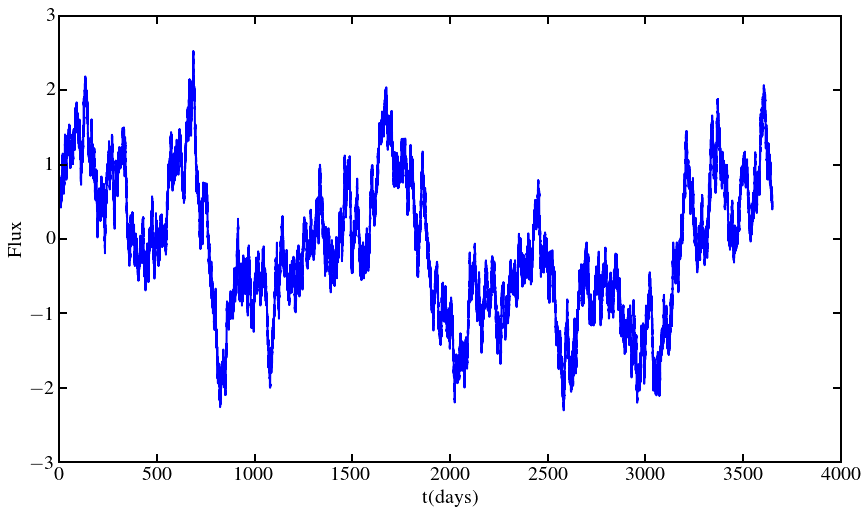

In [8]:
# plot simulated lightcurve
f = plt.figure()
plt.ylabel('Flux')
plt.xlabel('t(days)')
plt.plot(DRW_lc.t, DRW_lc.x) # x is the variation about the mean flux

### Add noise (based on 1000 SN ratio)

In [9]:
Task.observe(DRW_lc)

### Downsample DRW lc based on LSST cadence

In [16]:
dLC = lsstlc(pos_gap[0], pos_gap[1], obsHist['expDate'], DRW_lc, pos_gap[2])

In [17]:
Task.fit(dLC)

0

In [18]:
Task.set(dt, Task.bestTheta)

0

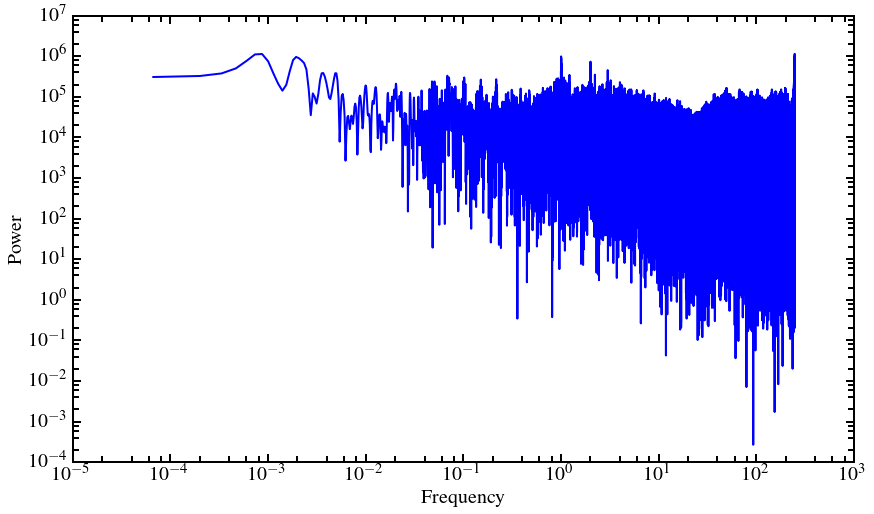

In [21]:
# plot periodogram using astropy
f, psd_sb, err = dLC.periodogram_sb()
#ratio = psdM[0]/psd_sb[0]
fig = plt.figure(figsize=(14,8))
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.loglog(f, psd_sb)
#plt.loglog(freqsM, psdM/ratio)

In [19]:
freqs, psd, psdnumerator, psddenominator, psdnumeratorcomponent, psddenominatorcomponent = Task.psd(start=1/DRW_lc.T, stop=1/DRW_lc.mindt)

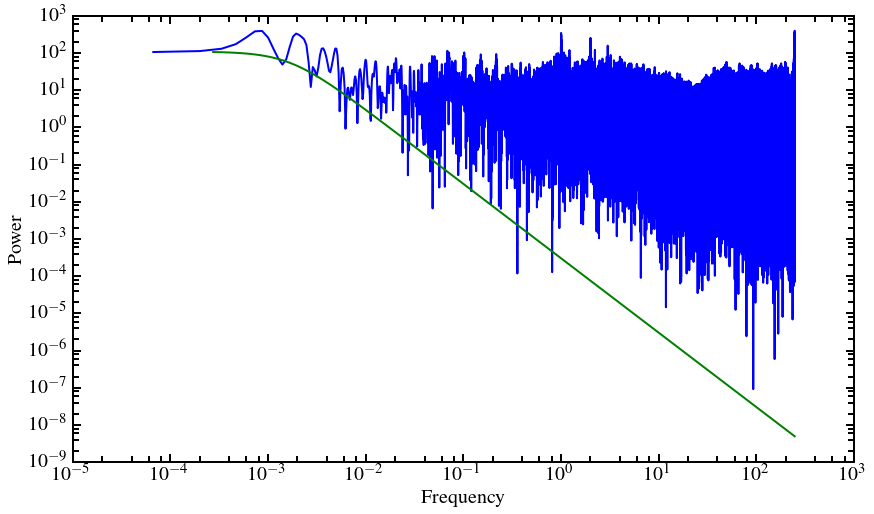

In [22]:
fig = plt.figure(figsize=(14,8))
plt.ylabel('Power')
plt.xlabel('Frequency')
ratio = psd[0]/psd_sb[0]
plt.loglog(f, psd_sb*ratio)
plt.loglog(freqs, psd)

In [12]:
from astropy import stats

In [13]:
ls = stats.LombScargle(DRW_lc.t, DRW_lc.y, DRW_lc.yerr, nterms=1)

In [24]:
f, psd_mock = ls.autopower(method='fast', normalization='psd', maximum_frequency=1/DRW_lc.mindt)

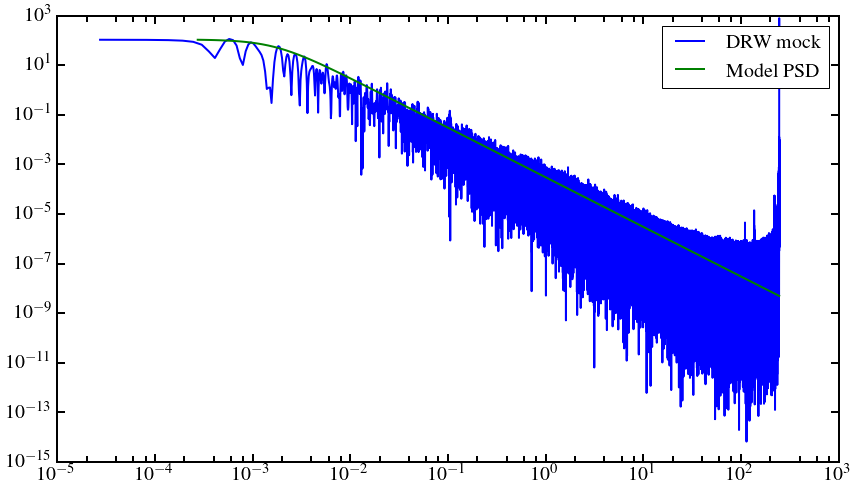

In [25]:
fig = plt.figure(figsize=(14,8))
ratio = psd[0]/psd_mock[0]
plt.loglog(f, psd_mock*ratio, label='DRW mock')
plt.loglog(freqs, psd, label='Model PSD')
plt.legend()